Training an LLM Base Model on Custom Dataset

In [ ]:
# !pip install transformers
# !pip install tokenizers
# !pip install --upgrade accelerate

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
torch.random.manual_seed(0)

In [ ]:
# load the pre trained model

model_name = 'allenai/OLMo-1B-0724-hf' # 25 GB VRAM, use A100 GPU # https://huggingface.co/allenai/OLMo-1B-0724-hf
# Changing model_name to any Base textGeneration model should work  #https://huggingface.co/models?pipeline_tag=text-generation

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
   model_name,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): OlmoRotaryEmbedding()
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
  )
  (

In [ ]:
# testing without finetuning base model
input_text = 'Hello how are you?'
input_ids = tokenizer.encode(input_text, return_tensors='pt').to('cuda')

output = model.generate(input_ids, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)

Hello how are you? I am fine. I have been busy with my work. How about you?"

"I am good. Thank you for asking."
  
She then said "I have a question for you. Do you have any idea about the meaning of life?"  


I was shocked.  I said, "No, I don't know."  She said that she had a friend who had an idea. She said she would tell me.
   



In [ ]:
# download book by the author.
# In our case students might filter the gutenberg library to get books by their favourite author and train the model to answer in
# the authors tone and may be generate a small story

# Sample books -for testing
#!wget https://raw.githubusercontent.com/brunoklein99/deep-learning-notes/master/shakespeare.txt -O shakespeare.txt

# All shakespeare books
!wget https://gist.githubusercontent.com/blakesanie/dde3a2b7e698f52f389532b4b52bc254/raw/76fe1b5e9efcf0d2afdfd78b0bfaa737ad0a67d3/shakespeare.txt -O shakespeare.txt

--2024-09-01 18:18:57--  https://gist.githubusercontent.com/blakesanie/dde3a2b7e698f52f389532b4b52bc254/raw/76fe1b5e9efcf0d2afdfd78b0bfaa737ad0a67d3/shakespeare.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5436475 (5.2M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   5.18M  --.-KB/s    in 0.06s   

2024-09-01 18:18:57 (82.5 MB/s) - ‘shakespeare.txt’ saved [5436475/5436475]



In [ ]:
# prepare the dataset

train_path = 'shakespeare.txt'
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_path,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
# set up training args
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_eval_batch_size=64,
    eval_steps=100,
    #save_steps=1000, # saves checkpoints, takes up disk
    warmup_steps=50,
    # logging
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=25,
    logging_first_step=True,
    report_to=["tensorboard"],

)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

In [ ]:
trainer.train()

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


TrainOutput(global_step=4656, training_loss=2.180167237763962, metrics={'train_runtime': 2710.0517, 'train_samples_per_second': 13.742, 'train_steps_per_second': 1.718, 'total_flos': 3.3657646372356096e+16, 'train_loss': 2.180167237763962, 'epoch': 3.0})

In [ ]:
output_dir = './results'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/tokenizer.json')

In [ ]:
del model
del tokenizer

In [ ]:
# Loading the new model from local dir
output_dir = './results'

tokenizer = AutoTokenizer.from_pretrained(output_dir)
model = AutoModelForCausalLM.from_pretrained(
   output_dir,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
model.to('cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): OlmoRotaryEmbedding()
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
  )
  (

In [ ]:
#Testing the new model
input_text = 'To be or not to be'
input_ids = tokenizer.encode(input_text, return_tensors='pt').to('cuda')

output = model.generate(input_ids, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)

To be or not to be- that is the question:
    If Lewis do will his marriage to my sister;
  KING EDWARD. If she deny, his title to the crown.
                                                  Exit WARWICK
   Now, Warwick, take the time to speak thy mind.

                           Enter OXFORD

  WAR WICK. Now, my Lord of Oxford, what says Oxford?
     Shall I, forsooth, have


Training loss curve

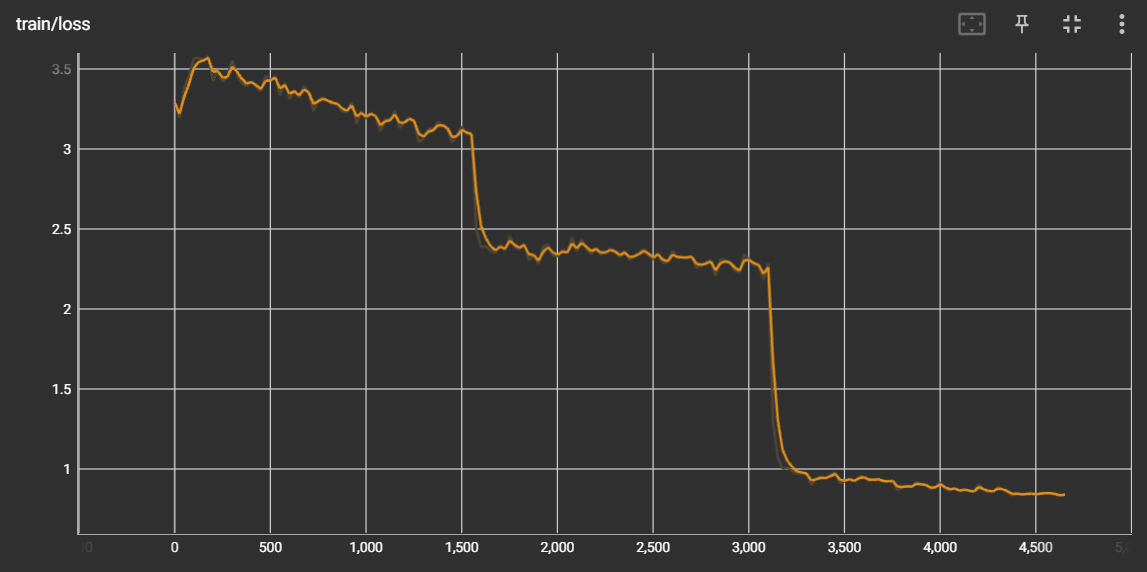